---
---
# Experiment: Regression on Compliance 
**AUTHOR:**   Athon Millane\ Amir Kamel
**DATE:** 02/07/2020

---

### Contents
1. [Imports and data loading](#1)
2. [Global variables and hyperparameters](#2)
3. [Data processing pipeline](#3)
4. [SKLearn regression](#4)
5. [Feature contribution summary](#5)
6. [Visualising PCA](#6)
---

<a name="1"></a>
## 1. Imports and data loading 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('../../src')
import pandas as pd
import matplotlib.pyplot as plt


from config import CURRENT, PROCESSED
from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, \
                             scale, melt, unmelt, remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap

---

<a name="2"></a>
## 2. Global variables and hyperparameters

In [3]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

# feature selection
DROP_X     = ['eotd_PEEP', 'ecmo_highest_PEEP_6hr_before', 
              'eotd_tidal_volume_ideal', 'eotd_tidal_volume_perkg', 'eotd_tidal_volume', 'ecmo_highest_tidal_volume_6hr_before', 
              'eotd_airway_plateau_pressure', 'ideal_weight','country','mech_vent_intubation_site','site_name']
SELECT_Y   = ['compliance_respiratory_system']

---

<a name="3"></a>
## 3. Data processing pipeline

In [4]:
# Experimemt params
ICU_ONLY = True
DAY = None
Y   = 'compliance_respiratory_system'

In [5]:
# processing
daily    = pd.read_csv(CURRENT/'daily.csv')
patients = pd.read_csv(CURRENT/'patients.csv')
patients_daily = daily.merge(patients, how='left', on='pin').set_index(['pin','date_daily']).sort_index()\
                      .reset_index().drop_duplicates(subset=['pin','date_daily']).set_index(['pin','date_daily'])\
                      .pipe(sort).pipe(replace_inf).pipe(drop_empty)
if DAY is not None:
    patients_daily = patients_daily[patients_daily['day'] == DAY]
    
if ICU_ONLY:
    patients_daily = patients_daily[patients_daily['day'] >= 0]

# numerical processing
patients_daily_num = patients_daily.pipe(select,'numerical').pipe(drop_by_nunique, 2)\
                                   .pipe(scale).pipe(remove_outliers).pipe(scale).pipe(sort).pipe(drop_empty)\
                                   .fillna(-1)

# categorical processing
patients_daily_binary = patients_daily_num.pipe(select,'numerical').pipe(drop_by_nunique, 1, 2)
patients_daily_cat = patients_daily.pipe(select, 'categorical').pipe(drop_by_nunique, 1)
patients_daily_cat = pd.merge(patients_daily_binary, patients_daily_cat, how='inner', left_index=True, right_index=True)
patients_daily_cat = patients_daily_cat.pipe(get_categories).pipe(filter_categorical, cutoff=20, plot=False)\
                                       .pipe(sort).fillna('other')
patients_daily_cat_oh = patients_daily_cat.pipe(onehot)

# merge numerical and categorical
processed = pd.merge(patients_daily_num.pipe(scale), patients_daily_cat_oh, left_index=True, right_index=True)
processed_X = processed.pipe(filter_regex, DROP_X+SELECT_Y)
processed_Y = processed.filter(regex='|'.join(SELECT_Y))
raw_Y = patients_daily.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(SELECT_Y)).pipe(remove_outliers)
df_y = raw_Y[SELECT_Y]

# specific to this particular experiment
df_y = df_y[df_y > 0]

# match df_X and df_y
df_X, df_y = match(processed_X, df_y)

In [6]:
# raw_Y

In [7]:
# merge numerical and categorical
processed_ = pd.merge(patients_daily_num.pipe(scale), patients_daily_cat, left_index=True, right_index=True)
processed_X_ = processed_.pipe(filter_regex, DROP_X+SELECT_Y)
processed_Y_ = processed_.filter(regex='|'.join(SELECT_Y))

# match df_X and df_y
df_X_,_ = match(processed_X_, df_y)

<a name="title"></a>
## THE QUESTION TO BE ANSWERED:
##    COMPLIANCE_RESPIRATORY_SYSTEM PREDICTOR

---

<a name="4"></a>
## 4. SKLearn RF Regression

In [8]:
from utils.modelling import fit_cv_plot
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# fig,axs=plt.subplots(1,2,figsize=[12,6])

# ests = [('Random Forest', RandomForestRegressor(n_estimators=200,
#                                                 max_depth=10,
#                                                 random_state=42)),
#         ('GBDT', GradientBoostingRegressor(n_estimators=200,
#                                            max_depth=10,
#                                           random_state=42))]
    
# results = fit_cv_plot(df_X, df_y[Y].values, axs, ests)

#new way below

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [9]:
import numpy as np
from utils.modelling import fit_cv_plot
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import pylab as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


    
# fig,axs=plt.subplots(1,2,figsize=[12,6])
X, y = df_X, df_y

groups = np.array(X.reset_index()['pin'].tolist())
# print(groups.shape)

gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
gss.get_n_splits()

cm = []
report = []
counter = 0
for train_idx, test_idx in gss.split(X, y, groups):
    #     print("TRAIN:", train_idx, "TEST:", test_idx)
    #     print("Length TRAIN:", len(train_idx), "Length TEST:", len(test_idx))
    counter = counter+1
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train[Y].values)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.8min finished


In [10]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(df_X, df_y[Y].values)

In [25]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [12]:
def evaluate(model, test_features, test_labels, model_type):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print(model_type+' Model Performance:')
    print(model_type+' Model Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print(model_type+' Model Accuracy = {:0.2f}%.'.format(accuracy))
    print("\n\n")
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train[Y].values)
base_accuracy = evaluate(base_model, X_test, y_test[Y].values, 'Base')

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test[Y].values, 'Best Random')

print('Overall Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Base Model Performance:
Base Model Average Error: 6.4462 degrees.
Base Model Accuracy = 79.50%.



Best Random Model Performance:
Best Random Model Average Error: 6.0598 degrees.
Best Random Model Accuracy = 80.72%.



Overall Improvement of 1.54%.


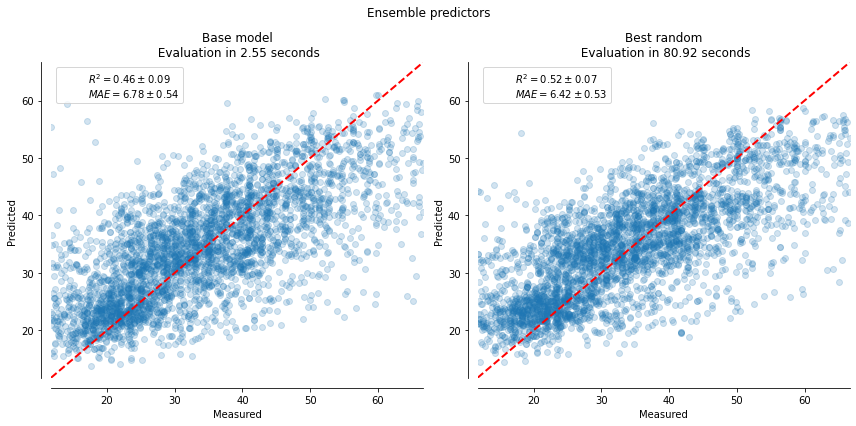

In [19]:
# rf_random.best_estimator_
fig,axs=plt.subplots(1,2,figsize=[12,6])

ests = [('Base model', base_model),
        ('Best random', rf_random.best_estimator_)]
    
results = fit_cv_plot(df_X, df_y[Y].values, axs, ests)

<a name=""></a>
## Grid Search with Cross Validation

In [14]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [400, 600, 800, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [24]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train[Y].values)
print("\n\n")
print("Best grid Search params:\n")
best_grid = grid_search.best_estimator_
best_grid
print("\n\n")
grid_accuracy = evaluate(best_grid, X_test, y_test[Y].values, 'Grid Search')

print('grid accuracy',grid_accuracy)
print('Overall Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 33.5min finished





Best grid Search params:




Grid Search Model Performance:
Grid Search Model Average Error: 6.0345 degrees.
Grid Search Model Accuracy = 80.79%.



grid accuracy 80.78791911534154
Overall Improvement of 1.62%.


In [27]:
best_grid

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

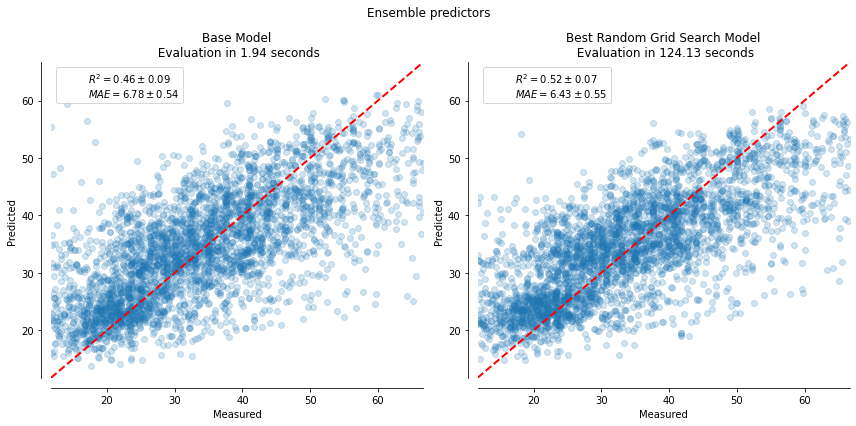

In [26]:
fig,axs=plt.subplots(1,2,figsize=[12,6])

ests = [('Base Model', base_model),
        ('Best Random Grid Search Model', best_grid)]
    
results = fit_cv_plot(df_X, df_y[Y].values, axs, ests)

<a name="shap"></a>
## WHAT IS SHAP?

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model.
It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

Original papers at:https://github.com/slundberg/shap#citations

<a name="5"></a>
## 5. SHAP: Build a Tree-Based Model

In [9]:
import numpy as np
import xgboost
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# train XGBoost model
X = df_X.copy()
y = df_y.copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2)
# train XGBoost model
xgtrain = xgboost.DMatrix(X_train, label=Y_train)
model = xgboost.train({"learning_rate": 0.01}, xgtrain, 100)
# param = {'eval_metric':'rmse'}
param = {'objective':'reg:squarederror'}
Cross_Validation = xgboost.cv(dtrain=xgtrain,params=param)
rmse =np.mean(Cross_Validation['test-rmse-std'])
print(f'R2 score: {rmse:.2f}')

R2 score: 0.24


<a name="5.1"></a>
## 5.1. SHAP: Init

In [10]:
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

<a name="5.2"></a>
## 5.2. SHAP: Feature Importance (Global Interpretability)

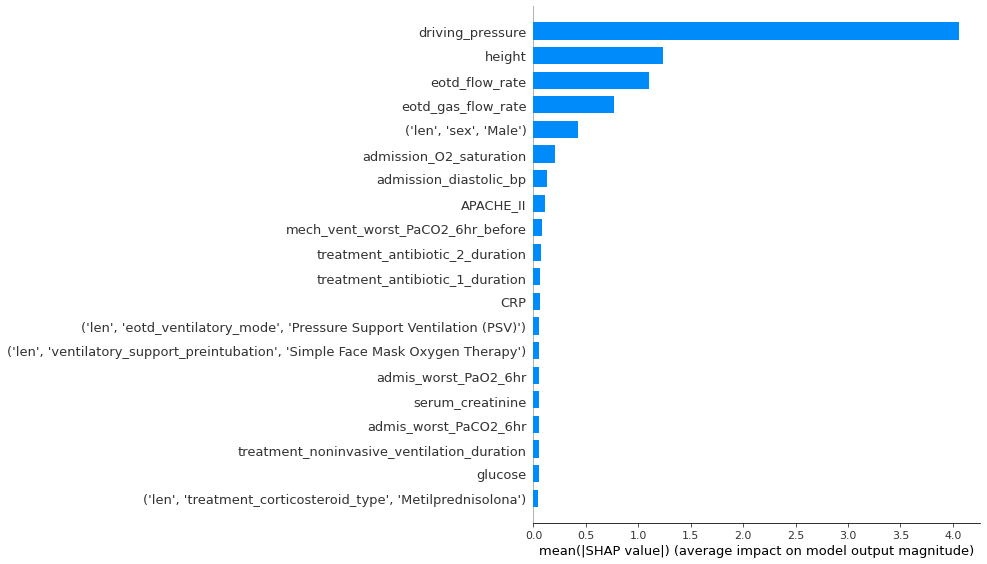

In [11]:
## A variable importance plot lists the most significant variables in descending order.
## The top variables contribute more to the model than the bottom ones and thus have high predictive power.

shap.summary_plot(shap_values, X_test, plot_type="bar")

<a name="5.3"></a>
## 5.3. Feature Importance — Local Interpretability

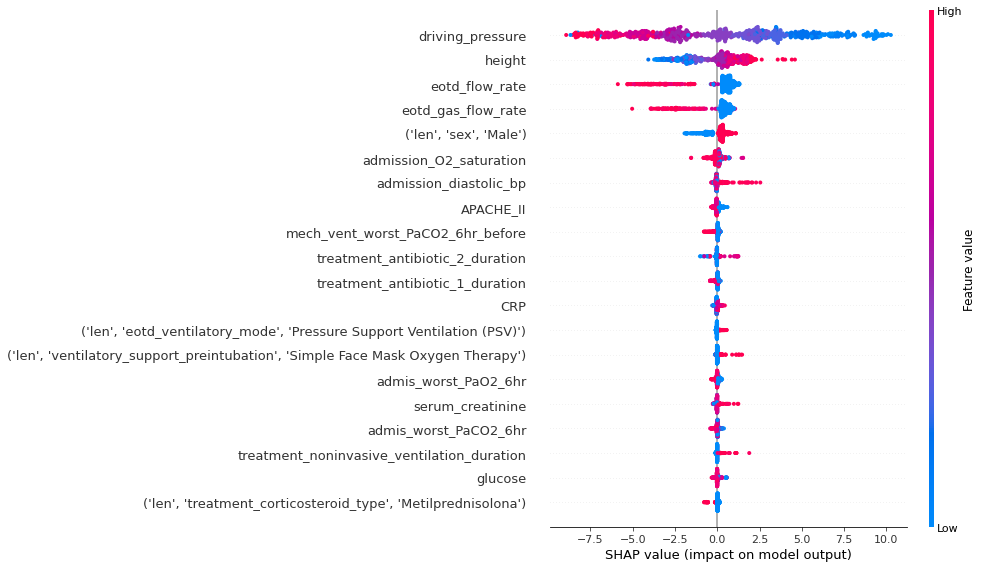

In [12]:
# summarize the effects of all the features
# The SHAP value plot can further show the positive and negative relationships of the predictors with the target variable. 
shap.summary_plot(shap_values, X_test)

<a name="5.4"></a>
## 5.4. SHAP: Positive and Negative relationships between Predictors with "Compliance_Respitoraty_System'  

In [13]:
# visualize the first prediction's explanation
# param1 = The base value or the expected value is the average of the model output over the training data X_train
# param2
# param3 = the matrix of feature values
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test.iloc[10,:])

In [14]:
pd.set_option('display.max_columns', None)
# Y_train.iloc[0:1,:]

<a name="5.5"></a>
## 5.5. SHAP: Dependency Plot'  

---

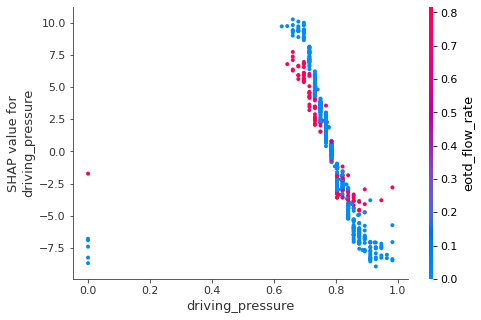

In [15]:
shap.dependence_plot('driving_pressure', shap_values, X_test)

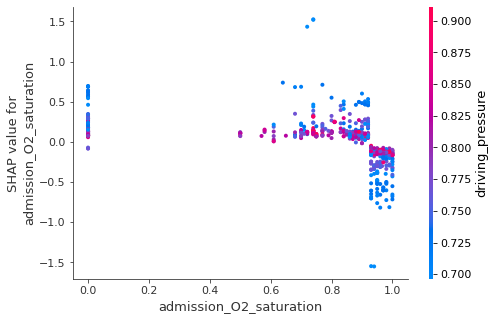

In [16]:
shap.dependence_plot('admission_O2_saturation', shap_values, X_test)

<a name="5"></a>
## 5. Feature contribution summary

In [ ]:
import seaborn as sns

def colour(df, n=10, cm=None):
    """Plot df in glorious technicolor.
    """
    if not cm:
        cm = sns.light_palette("green", as_cmap=True)
    display(df.head(n).style.background_gradient(cmap=cm))
    return df

def get_importance(df_X,results):
    """Return table of most important features according to different metrics.
    """
    importances = ([e.feature_importances_ for e in results['estimator']])
    features = df_X.columns.to_frame(name='feature').reset_index(drop=True)
    for i in range(len(importances)):
        features[f'importance_cv{i+1}'] = importances[i]
    features['importance_mean'] = features.filter(regex='importance').mean(axis=1)
    return features.sort_values(by='importance_mean',ascending=False)

def features_subset(features_in):
    """Return sorted list of features by importance.
    """
    features = features_in.copy()
    features['feature'] = features['feature'].apply(lambda x: x[1] if type(x) == tuple else x)
    return features.groupby(['feature'])['importance_mean'].sum().sort_values(ascending=False).to_frame(name='Feature Contribution')

In [ ]:
importances = get_importance(df_X, results['Random Forest']).pipe(colour)
features = features_subset(importances).pipe(colour)

### Iterate (Recursive feature elimination)

In [ ]:
subset = importances.head(10)['feature'].tolist()
ests = [('Random Forest', RandomForestRegressor(n_estimators=200,
                                                max_depth=10,
                                                random_state=42)),
        ('GBDT', GradientBoostingRegressor(n_estimators=2000,
                                           max_depth=10))]
fig,axs=plt.subplots(1,2,figsize=[12,6])
results_ = fit_cv_plot(df_X[subset], df_y[Y].values, axs, ests)
importances_ = get_importance(df_X[subset], results_['Random Forest'])
top_features = features_subset(importances_).pipe(colour)

In [ ]:
def pps_plot(df, cluster=False):
    import ppscore as pps
    import seaborn as sns
    pps.CV_ITERATIONS = 10
    df_matrix = pps.matrix(df)
    if cluster:
        _=sns.clustermap(df_matrix, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, dendrogram_ratio=(0.2,0.2))
    else:
        fig,ax=plt.subplots(1,1,figsize=[8,6])
        sns.heatmap(df_matrix, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True).set_title('Predictive Power Score')
        ax.set_xlabel('Feature'); ax.set_ylabel('Target')

df_pps = df_X_[features_subset(importances_).index.tolist()].merge(df_y[Y], left_index=True, right_index=True)
df_pps.pipe(pps_plot)
df_pps.pipe(pps_plot, cluster=True)

---

#### Compliance vs top features

In [ ]:
top_features

In [ ]:
compliance = pd.read_csv(PROCESSED/'first_crs.csv')
compliance_ = compliance[['pin']].merge(patients_daily.pipe(select,'numerical').pipe(remove_outliers, lower_quantile=0.01, upper_quantile=0.94).reset_index(), 
                                        how='left', left_on='pin', right_on='pin')[top_features.head(5).index.tolist()+[Y]]

In [ ]:
sns.set_palette("muted")

compliance_['Compliance Bin'] = pd.cut(compliance_.compliance_respiratory_system,bins=[0,30,50,100],labels=['Low (<30)','Medium (30-50)','High (>50)'])
with sns.axes_style("dark"):
    _=sns.pairplot(compliance_.drop('compliance_respiratory_system', axis=1), hue='Compliance Bin', kind="reg", height=2, plot_kws=dict(scatter_kws=dict(s=2)))

In [ ]:
comp = compliance_.drop('Compliance Bin', axis=1).melt(id_vars='compliance_respiratory_system')

with sns.axes_style("dark"):
    g = sns.FacetGrid(comp, hue="variable", col="variable", col_wrap=5, height=4, sharex=False, sharey=False)
g.map(sns.kdeplot, "compliance_respiratory_system", "value", shade=True, n_levels=5);

In [ ]:
sns.lmplot('value','compliance_respiratory_system',comp,hue="variable",col="variable",col_wrap=5,height=4,sharex=False,sharey=False,scatter_kws={"s": 5})

---

<a name="6"></a>
## 6. Visualising PCA 

In [ ]:
from utils.manifold import summary
sns.set_palette("coolwarm")
pd.merge(df_X, df_y[[Y]].pipe(scale), left_index=True, right_index=True).pipe(summary, exps=['PCA'], labels=df_y[[Y]]).pipe(cap)

In [ ]:
from utils.explanations import pca_explain, get_pc
summary = pd.merge(df_X, df_y.pipe(scale), left_index=True, right_index=True).pipe(get_pc)[['feature','pc_0_abs','pc_1_abs']]
summary['sum_abs_pc'] = summary['pc_0_abs'] + summary['pc_1_abs']
summary.sort_values('pc_0_abs',ascending=False).head(10).pipe(colour)
summary.sort_values('pc_1_abs',ascending=False).head(10).pipe(colour)
summary.sort_values('sum_abs_pc',ascending=False).head(10).pipe(colour)

---
---